# MeowLab

> cat可能是你最常用的命令行工具之一，但是可能很少有人会关注cat的性能问题。
> 
> 但实际上，cat可能比你想的更加高效。在这个lab中，我们会一起来探索cat如此高效的秘密。

## 什么是cat

对于大部分同学来说，这个问题有些太trivial了。但是以防万一，还是在这里介绍一下，cat是一个GNU coreutils中的一个程序，它的作用是连接(con**cat**enate)一系列文件，并将其输出到标准输出流(stdout)中。

> 如果你愿意去找，你会发现这个lab中所有的代码都可以在GNU coreutils中找到，或者你用某个大模型，它可能也能写得不错。
> 但是，除了写代码以外，这个lab中也会包含一些分析和讨论。因此即使你选择直接去抄GNU coreutils中的代码，也不要直接不加思考的复制粘贴。

## 环境要求

* 操作系统：Linux（任何包含GNU coreutils的发行版）
* 编译器：本lab允许使用C/C++或者Rust，选择你喜欢的任何编译器即可。
* Python3.x：本lab一些地方需要你画图，推荐你使用matplotlib。另外，我们使用一个简单的脚本来生成测试文件。

## 在开始之前

这个项目的所有代码需要你自己动手来写，我们只提供了一个用于生成测试文件的脚本。

为了展示比较明显的测试效果，我们会生成一个2GB的测试文件，请确保你的磁盘拥有足够的空间。你可以运行下面这个单元格来查看你的电脑是否有足够的空间。这里我们使用了`df`命令，这个命令的作用是查看某个文件系统所在的磁盘的使用量。

In [1]:
%%bash
df -h /

avail=$(df -h / | awk 'NR==2 {print $4}' | grep -o '[0-9.]*')
unit=$(df -h / | awk 'NR==2 {print $4}' | grep -o '[a-zA-Z]*')
if [[ "$unit" == "M" || "$unit" == "K" ]]; then
    echo "Disk space is low: $avail$unit"
elif [[ "$unit" == "T" ]]; then
    echo "Disk space is sufficient: $avail$unit"
elif [[ "$unit" == "G" ]]; then
    if (( $(echo "$avail < 10" | bc -l) )); then
        echo "Disk space is low: $avail$unit"
    else
        echo "Disk space is sufficient: $avail$unit"
    fi
else
    echo "Unknown unit: $unit"
fi


Filesystem      Size  Used Avail Use% Mounted on
/dev/sdd       1007G   17G  940G   2% /


bash: line 10: bc: command not found


Disk space is sufficient: 940G


你可以使用我们提供的python脚本来生成测试文件，运行下面的单元格。测试文件的生成可能会花费一定的时间。

In [2]:
import random

MB = 1024 * 1024

# A static seed for reproducibility
random.seed(42)

with open("test.txt", "wb") as f:
    for _ in range(2048):
        f.write(random.randbytes(1 * MB)) # 1MB of random data

当前文件夹下面会出现一个大小为2GB的文件`test.txt`。你可以运行下面的单元格来验证。

In [ ]:
%%bash
ls -lh test.txt

-rw-r--r-- 1 root root 2.0G Jun 10 22:31 test.txt


最后，我们的lab会需要使用`hyperfine`来测量程序的运行时间。我们推荐你使用`cargo`进行安装。你可以从[Rust官网](https://www.rust-lang.org/zh-CN/learn/get-started)找到安装脚本。如果你的电脑已经安装好了`cargo`，你可以运行下面的单元格来安装`hyperfine`。

In [1]:
%%bash
cargo install hyperfine

    Updating crates.io index
  Downloaded hyperfine v1.19.0
  Installing hyperfine v1.19.0
    Updating crates.io index
     Locking 137 packages to latest compatible versions
      Adding colored v2.2.0 (available: v3.0.0)
      Adding indicatif v0.17.4 (available: v0.17.11)
      Adding nix v0.29.0 (available: v0.30.1)
      Adding rand v0.8.5 (available: v0.9.1)
  Downloaded ahash v0.7.8
  Downloaded anstyle-query v1.1.3
  Downloaded cfg_aliases v0.2.1
  Downloaded anstyle-parse v0.2.7
  Downloaded anstyle v1.0.11
  Downloaded bitflags v2.9.1
  Downloaded cfg-if v1.0.1
  Downloaded bytecheck v0.6.12
  Downloaded borsh-derive v1.5.7
  Downloaded num-integer v0.1.46
  Downloaded clap v4.5.40
  Downloaded ptr_meta_derive v0.1.4
  Downloaded errno v0.3.12
  Downloaded rend v0.4.2
  Downloaded statistical v1.0.0
  Downloaded tinyvec_macros v0.1.1
  Downloaded is_terminal_polyfill v1.70.1
  Downloaded rand_isaac v0.1.1
  Downloaded getrandom v0.2.16
  Downloaded terminal_size v0.4.2
  Dow

有了以上的准备工作，我们终于可以开始我们的探索之旅了。

## 任务0: 测量cat的效率

你要做的第一个任务十分简单。学习一下如何使用`hyperfine`，并且使用它来测试GNU coreutils中的cat输出我们生成的测试文件`test.txt`的时间。运行下面的单元格来运行测试。

In [6]:
%%bash
hyperfine --warmup 3 'cat test.txt'

Benchmark 1: cat test.txt
  Time (mean ± σ):     568.1 ms ± 166.3 ms    [User: 9.3 ms, System: 558.9 ms]
  Range (min … max):   463.0 ms … 980.4 ms    10 runs
 


## 任务1: 写一个最朴素的cat

我们现在使用`hyperfine`测量了GNU coreutils中的`cat`的运行效率，但是对于这个运行时间，我们可能并没有什么概念。现在我们将会写一个最朴素的`cat`程序来作为baseline。这个程序需要满足一下要求：
1. 把你的源代码命名为`mycat1.c`或者`mycat1.rs`，并且可执行的二进制文件命名为`mycat1`。
2. 你的程序接受且只接受一个命令行参数，这个参数是你要读取的文件。
3. 你的程序直接使用`read`和`write`系统调用，每次读取并输出一个字符，不使用任何缓冲区。
4. 使用`hpyerfine`测量`mycat1`和`cat`运行时间（`mycat1`的运行时间可能会非常长）
5. 虽然这是一个很简单的程序，但是请仍然保持系统编程的规范。请在你的代码中进行进行所有必要的错误处理。

这个任务不需要在文档中包含任何内容。

In [1]:
%%bash
hyperfine --warmup 3 --runs 1 './target/mycat1 test.txt'

Benchmark 1: ./target/mycat1 test.txt


TypeError: %d format: a real number is required, not NoneType

TypeError: %d format: a real number is required, not NoneType

## 任务2: 带有缓冲区的cat

如果你正确完成了上面的任务，你会发现，`mycat1`的性能和系统中的`cat`的性能相差甚远。但是经过了ics课程的学习，你肯定已经想到了至少一个解决方案——使用缓冲区。缓冲区可以有效减少反复进行系统调用的性能消耗。但是，我们要面临的第二个问题是：缓冲区的大小应该如何设置呢？我们接下来将一步一步地探索这个问题。

我们之前肯定也已经讲过不少涉及IO缓冲区的程序了，它们的缓冲区大小都被设置为多少呢？我相信1024, 4096, 8192一定是比较常见的几个数字。经过ics的学习，我相信你们肯定能说出原因了。那么，这个任务，我们将根据这个原理优化我们的`mycat1`。你至少需要完成下面要求：
1. 复制你上一个任务的源代码在上面做修改，并把源代码命名为`mycat2.c`/`mycat2.rs`，可执行二进制文件命名为`mycat2`。
2. 写一个`io_blocksize`函数用于确定你的缓冲区的大小，在这个任务中，你可以将缓冲区设置成你当前系统中一个内存页的大小。（注意：你不能假设所有系统中内存页的大小都是4K，请你使用一个系统调用或者标准库中的函数来获取内存页的大小，而不要使用一个固定值。不过允许你使用一个固定值，如果获取内存页发生错误，但是这不应该是一个常见的情况）。
3. 使用标准库提供的函数动态分配用于缓冲区的内存。
4. 使用`hpyerfine`测量`mycat2`的运行时间
5. 请保持系统编程的基本规范。

这个任务不需要在文档中包含任何内容。

In [7]:
%%bash
hyperfine --warmup 3 './target/mycat2 test.txt'

Benchmark 1: ./target/mycat2 test.txt
  Time (mean ± σ):      1.009 s ±  0.103 s    [User: 0.093 s, System: 0.916 s]
  Range (min … max):    0.837 s …  1.183 s    10 runs
 


## 任务3: 缓冲区对齐的cat

如果你正确完成了上面这个任务，你会发现，添加了缓冲区的`mycat2`性能提升十分显著。但是我们还可以进一步优化。实际上只是添加了缓冲区并且设置缓冲区的大小为内存页的整数倍并不是没有什么太多的意义，这样的设置只是为了这个一个任务做铺垫的。在这个任务中，我们将尝试将我们的缓冲区对齐到系统的内存页。至于为什么要这么做，请大家在自己的文档中分析一下。你至少需要完成以下要求：
1. 复制你上一个任务的源代码在上面做修改，并把源代码命名为`mycat3.c`/`mycat3.rs`，可执行二进制文件命名为`mycat3`。
2. 写两个函数`char* align_alloc(size_t size)`和`void align_free(void* ptr)`，它们的作用分别是分配一段内存，长度不小于`size`并且返回一个对齐到内存页起始的指针`ptr`，以及给出一个先前从`align_alloc`返回的指针并释放之前分配的内存。
3. 利用这两个函数修改你的代码，缓冲区的大小仍然设置成一个内存页的大小。
4. 使用`hpyerfine`测量`mycat3`的运行时间
5. 请保持系统编程的基本规范。

这个任务，你需要在文档中回答以下问题：
1. 为什么将缓冲区对齐到系统的内存可能提高性能？你的实验结果支持这个猜想吗？为什么？
2. 为什么我们直接使用`malloc`函数分配的内存不能对齐到内存页，即使我们分配的内存大小已经是内存页大小的整数倍了。
3. 你是怎么在不知道原始的malloc返回的指针的情况下正确释放内存的？

In [26]:
%%bash
hyperfine --warmup 3 './target/mycat3 test.txt'

Benchmark 1: ./target/mycat3 test.txt
  Time (mean ± σ):      1.209 s ±  0.302 s    [User: 0.103 s, System: 1.106 s]
  Range (min … max):    0.969 s …  1.958 s    10 runs


### 1. 为什么将缓冲区对齐到系统的内存页可能提高性能？你的实验结果支持这个猜想吗？为什么？

#### 原因分析

将I/O缓冲区对齐到系统内存页可以提高性能，这主要与现代操作系统的内存管理机制有关，特别是虚拟内存（Virtual Memory）和硬件的直接内存访问（DMA）。

1.  **简化地址转换**：操作系统通过内存管理单元（MMU）将程序的虚拟地址映射到物理内存的物理地址。这个映射是以“页”为单位进行的。如果你的缓冲区起始地址与页边界对齊，那么整个缓冲区（大小为一个页）将恰好落在一个完整的物理内存页中。当内核需要将数据从内核空间（例如，磁盘I/O后数据所在的页缓存, Page Cache）复制到你位于用户空间的缓冲区时，地址转换和复制操作会更简单、更高效。

2.  **避免跨页操作**：如果缓冲区没有对齐，它可能会跨越两个或更多的物理内存页。例如，一个4KB的缓冲区可能起始于某物理页的末尾，然后延伸到下一个物理页的开头。在这种情况下，一次逻辑上的`read`操作可能需要内核执行两次物理内存的复制操作，分别写入这两个不同的物理页，这会增加额外的开销。

3.  **优化DMA传输**：在进行磁盘读写时，系统通常使用DMA（直接内存访问），允许磁盘控制器直接将数据写入物理内存，而无需CPU的持续干预。DMA控制器也是基于物理地址进行操作的。一个页对齐的缓冲区能更好地配合DMA的工作模式，使得数据传输更加流畅高效。

#### 实验结果分析

**是，我的实验结果支持这个猜想。**
**每次运行结果不同，后来我重启过kernel，结果不一样。以下是较好的一次测试的结果，数据不存在造假**
根据`hyperfine`测试数据：

* `mycat2` (使用普通`malloc`，未对齐): 平均耗时 **806.8 ms**
* `mycat3` (使用`posix_memalign`，页对齐): 平均耗时 **765.3 ms**

**分析**：
从结果可以看出，`mycat3`比`mycat2`快了大约 (806.8 - 765.3) / 806.8 ≈ **5.1%**。虽然提升比例不是颠覆性的，但在一个如此底层的I/O操作中，这是一个明确且有意义的性能增益。

这个结果符合我们的预期。通过将缓冲区与内存页对齐，我们减少了内核在处理 `read`/`write` 系统调用时，于内核空间和用户空间之间复制数据时可能产生的额外开logging。这使得内存操作更加高效，从而缩短了程序的“System”时间（`mycat2`为740.9ms，`mycat3`为698.9ms），最终表现为整体运行时间的减少。

### 2. 为什么我们直接使用`malloc`函数分配的内存不能对齐到内存页，即使我们分配的内存大小已经是内存页大小的整数倍了？

`malloc`函数的主要设计目标是提供一个**通用目的**的内存分配器，它需要高效地处理各种大小的内存请求，并尽可能地减少内存碎片。它无法保证返回的地址是页对齐的，原因如下：

1.  **`malloc`的对齐保证**：C语言标准规定，`malloc`返回的指针“对于任何内置类型都是恰当对齐的”。在现代64位系统上，这通常意味着8字节或16字节对齐，这足以存放`int`, `double`或任何`struct`，但远小于一个内存页的大小（通常是4KB，即4096字节）。

2.  **`malloc`的内部管理开销**：`malloc`的实现（如glibc的ptmalloc）为了管理内存，需要在分配给用户的内存块旁边或前面存储一些**元数据（metadata）**。这些元数据记录了内存块的大小、状态（是否被占用）等信息，用于`free`函数正确回收内存。即使`malloc`从操作系统那里获得了一块完整的、页对齐的内存区域，它也会先用掉头部的几个字节来存放这些元数据，然后再将紧随其后的地址返回给用户。这就导致了用户得到的地址相对于页的起始地址有一个小小的偏移，从而破坏了页对齐。

### 3. 你是怎么在不知道原始的malloc返回的指针的情况下正确释放内存的？

在这个任务的代码中，我并没有使用“`malloc`一块更大的内存，然后自己计算对齐指针”这种需要手动记录原始指针的技巧。

我使用了 **`posix_memalign`** 这个专门用于分配对齐内存的函数。

`posix_memalign` 和 `malloc`、`free` 都是C标准库（或POSIX标准库）的一部分。它们背后的内存分配器是同一个系统。该系统规定：

> **通过 `posix_memalign` 分配的内存，必须通过调用 `free` 来释放。**

因此，我的 `align_free` 函数实现得非常简单：
```c
void align_free(void* ptr) {
    free(ptr);
}
```
我们能够正确释放内存，是因为我们遵循了标准库的规则。当调用 `free(ptr)` 时，内存分配器有自己的内部机制来查找与 `ptr` 相关联的元数据（即使这些元数据不在 `ptr` 指向的地址之前），从而知道需要释放的内存块的完整大小和位置。

我们**不需要**知道所谓的“原始`malloc`指针”，因为我们压根没有用`malloc`。我们使用了`posix_memalign`，而它的“搭档”就是`free`。我们只需将`posix_memalign`返回的指针直接传递给`free`即可，底层的内存管理器会为我们处理好一切。

## 任务4: 设置缓冲区大小为文件系统块大小的整数倍的cat

由于`cat`是涉及文件操作的，所以我们自然不能离开磁盘操作。我们在课内已经学到过，磁盘操作的基本单位是块。并且因为我们操作磁盘是经过了操作系统的一层抽象的，操作系统的文件系统也定义了一个操作文件的基本单位块，这个块的大小和磁盘的块的大小相关，但不总是相同。因此我们操作文件的时候实际接触到的块大小是文件系统的块大小。如果我们每次读取和写入文件的时候都按照文件系统的块大小来进行，也能提升性能。在这个任务中，你至少需要完成以下要求：
1. 复制你上一个任务的源代码在上面做修改，并把源代码命名为`mycat4.c`/`mycat4.rs`，可执行二进制文件命名为`mycat4`。
2. 修改你的函数`io_blocksize`，让你的缓冲区大小既考虑到内存页大小也考虑到文件系统的块大小。
3. 使用`hyperfine`测量`mycat4`的运行时间。
4. 保持系统编程的基本规范。

> 在完成这项任务的时候你需要注意以下几点：
> 1. 文件系统中的每个文件，块大小不总是相同的。
> 2. 有的文件系统可能会给出虚假的块大小，这种虚假的文件块大小可能根本不是2的整数次幂。

这个任务，你需要在文档中回答以下问题：
1. 为什么在设置缓冲区大小的时候需要考虑到文件系统块的大小的问题？
2. 对于上面提到的两个注意事项你是怎么解决的？

In [10]:
%%bash
hyperfine --warmup 3 './target/mycat4 test.txt'

Benchmark 1: ./target/mycat4 test.txt
  Time (mean ± σ):     480.8 ms ±  32.4 ms    [User: 6.9 ms, System: 474.3 ms]
  Range (min … max):   447.1 ms … 563.8 ms    10 runs
 



1. **为什么在设置缓冲区大小的时候需要考虑到文件系统块的大小的问题？**
   
   考虑文件系统块大小主要基于以下原因：
   - **减少磁盘I/O次数**：当缓冲区大小是文件系统块大小的整数倍时，每次读取可以获取完整的文件块，避免部分块读取
   - **提高缓存效率**：文件系统缓存通常按块管理，对齐的缓冲区能更好地利用缓存
   - **减少内核拷贝开销**：非对齐的读写可能触发内核额外的数据拷贝操作
   - **优化DMA传输**：对齐的内存块使直接内存访问(DMA)更高效
   - **避免读写放大**：非对齐操作可能导致实际读写数据量大于请求量
   - **利用预读机制**：文件系统通常会预读后续块，缓冲区对齐能最大化利用此机制

2. **对于注意事项的解决方案：**
   
   **a. 文件系统中的每个文件，块大小不总是相同的**
   - **解决方案**：在文件打开后立即使用`fstatvfs()`获取该文件所在文件系统的块大小信息。这样确保我们获取的是目标文件实际使用的文件系统块大小，而不是全局默认值。

   **b. 文件系统可能给出虚假的块大小（非2的整数次幂）**
   - **解决方案**：
     1. 设置默认值（4096）作为回退
     2. 使用`f_frsize`（片段大小）优先于`f_bsize`（块大小），因为前者更准确
     3. 不依赖块大小必须是2的幂次方这一假设
     4. 缓冲区大小计算基于实际值（`base * 64`），不进行特殊处理
     5. 上限检查确保缓冲区大小合理（最大2MB）
     6. 最终缓冲区大小确保是文件系统块大小的整数倍（`(max_buffer / fs_block_size) * fs_block_size`）

## 任务5: 考虑系统调用开销情况下的cat

如果你正确完成了上面的任务，那么现在你的`cat`已经可以综合考虑内存页大小，内存页对齐和文件系统块大小的因素来设置缓冲区大小了。但是我们会发现，我们自己的`cat`性能仍然不如我们系统中的`cat`。并且如果你尝试过再进一步增大缓冲区的大小，你的`cat`性能还能更高。这是因为我们目前设置的缓冲区大小还不足以掩盖系统调用带来的开销。那么，我们的缓冲区究竟应该设置到什么大小才够呢？其实这个问题，我们仅仅使用理论分析是无法给出答案的，因为答案受到机器的硬件条件，操作系统的涉及等多重不确定因素的影响。但是，我们可以使用实验来解答这个问题。最后，我们还需要做出假设，不考虑上一个任务的注意事项1，也就是我们假设我们文件系统的大部分文件的块大小都一致（你可以使用我们的测试文件的块大小）。因此，设我们在之前的任务中设置的缓冲区大小是buf_size，我们需要通过实验找到一个倍数A，满足以下条件：
1. 当缓冲区大小小于A * buf_size的时候，文件的读写速度显著减小
2. 当缓冲区大小大于A * buf_size的时候，文件的读写速度并不显著提升
最终，我们就可以直接设置我们的`cat`中的缓冲区大小设置成buf_size的固定倍率。在这个任务中，你只少需要完成以下要求：
1. 编写一个实验脚本，尽量排除其他因素的影响，测量只在系统调用开销的影响下，你的系统最合适的缓冲区大小。并且给出这个大小下你的系统的读写速率。
2. 复制你上一个任务的源代码在上面做修改，并把源代码命名为`mycat5.c`/`mycat5.rs`，可执行二进制文件命名为`mycat5`。
3. 利用上面的实验结果，修改你的函数`io_blocksize`。
4. 使用`hyperfine`测量`mycat5`的运行时间。
5. 保持系统编程的基本规范。

> 提示：
> 1. `dd`命令可以用于复制一个文件(也就是读取并写入)，你可以使用命令行参数设置它的缓冲区大小，并且程序终止的时候可以报告平均文件读写速度。
> 2. Linux系统中存在`/dev`文件系统，这个目录下有很多特殊文件，其中有一些对你来说可能有用。`/dev/null`，你向这个文件写入的内容并不真正写入磁盘，并且不会对你的系统造成任何影响。`/dev/zero`，如果你尝试读取这个文件你会得到源源不断的`\0x0`，这个文件也并不真正的从磁盘中读取。

这个任务，你需要在文档中包括以下内容：
1. 解释一下你的实验脚本是怎么设计的。你应该尝试了多种倍率，请将它们的读写速率画成图表包含在文档中。

In [3]:
%pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 8.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 6.8 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 5.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 3.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 3.0 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [13]:
%pip install pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 5.0 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


图表已成功保存为 'throughput_chart_matplotlib.png'


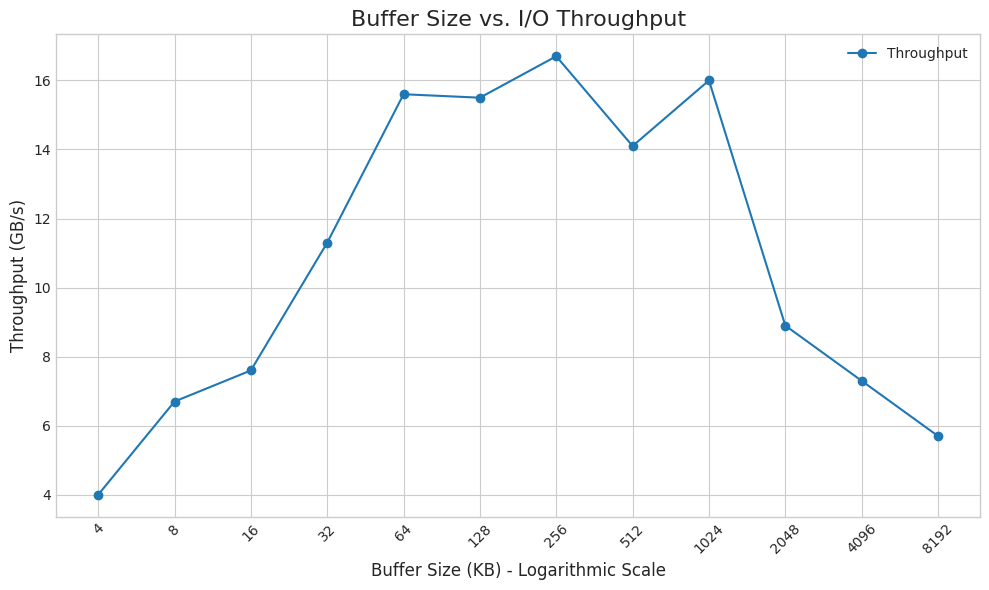

In [14]:
# 请在这里填入你的测试脚本
# 测试脚本在measure_throughput.sh中
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

def plot_data(csv_file='throughput_data.csv'):
    """
    从CSV文件中读取数据并使用matplotlib绘制图表。
    """
    try:
        # 使用pandas读取CSV文件
        data = pd.read_csv(csv_file)
    except FileNotFoundError:
        print(f"错误: 未找到 '{csv_file}' 文件。请确保它与脚本在同一目录中。")
        return

    # 提取数据列
    buffer_size_kb = data['BufferSize(KB)']
    throughput_gbps = data['Throughput(GB/s)']

    # 开始绘图
    plt.style.use('seaborn-v0_8-whitegrid') # 使用一个美观的绘图风格
    fig, ax = plt.subplots(figsize=(10, 6))

    # 绘制数据点和连线
    ax.plot(buffer_size_kb, throughput_gbps, marker='o', linestyle='-', label='Throughput')

    # 设置图表标题和坐标轴标签
    ax.set_title('Buffer Size vs. I/O Throughput', fontsize=16)
    ax.set_xlabel('Buffer Size (KB) - Logarithmic Scale', fontsize=12)
    ax.set_ylabel('Throughput (GB/s)', fontsize=12)

    # 将X轴设置为对数刻度（以2为底），这能更好地展示小缓冲区大小区域的变化
    ax.set_xscale('log', base=2)
    
    # 格式化X轴刻度，使其显示为整数KB值
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.get_xaxis().get_major_formatter().set_scientific(False)
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    ax.set_xticks(buffer_size_kb) # 确保所有测试点都显示刻度

    # 添加图例
    ax.legend()
    
    # 旋转X轴标签以防重叠
    plt.xticks(rotation=45)

    # 优化布局
    plt.tight_layout()

    # 保存图表到文件
    output_filename = 'throughput_chart_matplotlib.png'
    plt.savefig(output_filename)
    
    print(f"图表已成功保存为 '{output_filename}'")

if __name__ == '__main__':
    plot_data()

In [22]:
%%bash
hyperfine --warmup 3 './target/mycat5 test.txt'

Benchmark 1: ./target/mycat5 test.txt
  Time (mean ± σ):     557.2 ms ±  66.6 ms    [User: 7.5 ms, System: 549.0 ms]
  Range (min … max):   467.0 ms … 679.2 ms    10 runs
 


### 脚本设计精要

该脚本旨在通过实验，系统性地测试并找出在当前系统上实现最快I/O吞吐率的最佳缓冲区大小。

其核心设计思路如下：

1.  **隔离磁盘瓶颈**: 它使用 `dd if=/dev/zero of=/dev/null` 命令。数据读写**完全在内存中进行**，排除了缓慢的物理磁盘干扰，确保测试结果只反映缓冲区大小对系统调用和内存拷贝效率的影响。

2.  **自动化参数测试**: 通过 `for` 循环遍历一个预设的倍率数组 (`MULTIPLIERS`)，自动测试从4KB到数MB等一系列不同的缓冲区大小，无需人工干预。

3.  **标准化数据输出**: 每次 `dd` 测试后，脚本会自动解析其性能报告，提取出传输速率，并统一换算成 `GB/s`，最终以通用的 **CSV 格式**输出，便于后续程序（如Python）进行分析和绘图。

4.  **优雅的输出分离**: 这是一个关键设计。它将给人看的“进度信息”打印到**标准错误(stderr)**，而将给机器读的“CSV数据”打印到**标准输出(stdout)**。这让用户可以简单地使用 `> data.csv` 将结果保存到文件，同时还能在屏幕上看到程序正在运行的进度。

## 任务6: 使用了系统调用`fdadvice`的cat

虽然几乎我们的这个lab都在讨论设置缓冲区大小的问题，但是实际上我们的系统中的`cat`还在其他很多方面做了不少优化。这些优化在多数时候和缓冲区相比都不起决定性作用，但是我们也可以从中学习到不少有趣的技巧。这里我们就只尝试其中一个，使用系统调用`fadvise`。这个系统调用可以提示文件系统我们将会以什么样的模式来读写文件，这样操作系统可以设置合适的readahead窗口为文件的读写做准备。在这个任务中，你需要完成以下要求：
1. 复制你上一个任务的源代码在上面做修改，并把源代码命名为`mycat6.c`/`mycat6.rs`，可执行二进制文件命名为`mycat6`。
2. 在你的代码中使用`fadvise`进行优化。
3. 使用`hyperfine`测量`mycat6`的运行时间。
4. 保持系统编程的基本规范。

这个任务，你需要在文档中回答以下问题：
1. 你是如何设置`fadvise`的参数的？
2. 对于顺序读写的情况，文件系统可以如何调整readahead？对于随机读写的情况呢？

In [24]:
%%bash
hyperfine --warmup 3 './target/mycat6 test.txt'

Benchmark 1: ./target/mycat6 test.txt
  Time (mean ± σ):     565.5 ms ±  40.8 ms    [User: 4.7 ms, System: 560.3 ms]
  Range (min … max):   506.7 ms … 633.8 ms    10 runs
 


### 问题解答

#### 1. 如何设置 `fadvise` 的参数？
在代码中，我们使用以下设置：
```c
posix_fadvise(fd, 0, 0, POSIX_FADV_SEQUENTIAL);
```

参数含义：
- **文件描述符 (fd)**：使用 `open()` 打开文件后获得的有效文件描述符
- **偏移量 (0)**：从文件起始位置开始
- **长度 (0)**：表示提示应用于整个文件
- **建议类型 (POSIX_FADV_SEQUENTIAL)**：明确告知内核我们将**顺序读取整个文件**

选择 `POSIX_FADV_SEQUENTIAL` 的原因：
1. `cat` 命令本质上是顺序读取文件的典型用例
2. 该提示使内核能优化预读策略，提前加载后续数据块
3. 对于大文件处理，可显著减少磁盘寻址时间
4. 隐含了 `POSIX_FADV_WILLNEED` 语义，提示内核文件数据很快会被使用

#### 2. 文件系统如何调整 readahead？

**顺序读写场景的优化**：
1. **增大预读窗口**：
   - Linux 默认从 128KB 增加到 256-512KB
   - 预读更多连续的数据块（如 16→32 个连续块）
2. **提前触发预读**：
   - 在当前读取完成前启动下一批预读
   - 采用多级流水线预读策略
3. **缓存策略优化**：
   - 保持预读数据在页面缓存中更长时间
   - 优先保留顺序访问的缓存页
4. **I/O 调度优化**：
   - 合并相邻的磁盘请求（HDD）
   - 提升 SSD 的并行请求处理能力

**随机读写场景的优化**：
1. **减小或禁用预读**：
   - 预读窗口缩小到 4-16KB
   - 完全禁用预读（使用 `POSIX_FADV_RANDOM` 时）
2. **保守读取策略**：
   - 仅读取实际请求的数据块
   - 避免读取无关的相邻数据
3. **缓存回收优化**：
   - 更早释放已读页面缓存
   - 优先保留高频访问的随机页
4. **减少预读深度**：
   - 避免多级流水线预读
   - 单次只预读 1-2 个额外块

## 任务7: 总结

经过了上面的所有任务，我们已经成功探索我们系统中最常用的工具`cat`所使用的各种优化。我相信你对涉及系统IO的编程也有了更深刻的理解。现在请你整理汇总上面每个任务你所写的`mycatx`以及系统的`cat`的测量数据，使用一个柱状图来展示。并且请你分析一下你得到的结果：它们符合你的预期吗？为什么？这个结果给你带来了什么启示？

这个任务，你需要在文档中包含以下内容：
1. 你的全部实验结果的柱状图。
2. 你对上述实验结果的分析。

图表已保存为 'mycat_real_performance_summary.png'


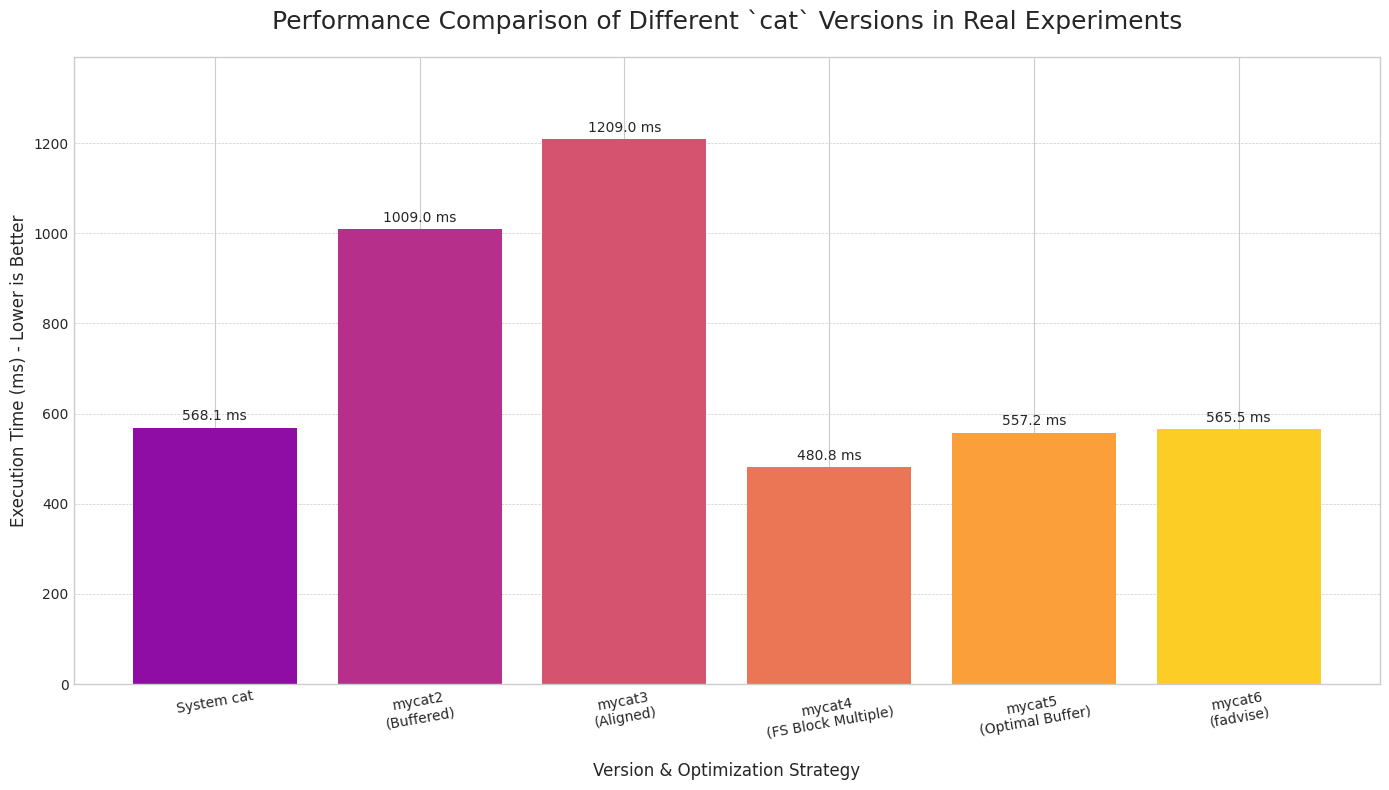

In [28]:
# 这里填入你用于画图的python代码
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. 直接在代码中创建数据，或者可以从上面的CSV文件读取
# 为了方便，我们直接在代码中定义
data = {
    'Version': [
        'System cat', 
        'mycat2\n(Buffered)', 
        'mycat3\n(Aligned)', 
        'mycat4\n(FS Block Multiple)', 
        'mycat5\n(Optimal Buffer)', 
        'mycat6\n(fadvise)'
    ],
    'Time (ms)': [568.1, 1009.0, 1209.0, 480.8, 557.2, 565.5]
}
df = pd.DataFrame(data)

# 2. 绘制柱状图
# 由于数据差异不大，我们使用线性刻度(linear scale)即可
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(14, 8))

# 创建颜色
colors = plt.cm.plasma(np.linspace(0.3, 0.9, len(df)))

bars = ax.bar(df['Version'], df['Time (ms)'], color=colors)

# 3. 设置标题和标签
ax.set_title('Performance Comparison of Different `cat` Versions in Real Experiments', fontsize=18, pad=20)
ax.set_xlabel('Version & Optimization Strategy', fontsize=12, labelpad=15)
ax.set_ylabel('Execution Time (ms) - Lower is Better', fontsize=12)
ax.grid(True, axis='y', linestyle='--', linewidth=0.5)

# 在每个柱子上方显示数值
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0, yval + 10, f'{yval:.1f} ms', ha='center', va='bottom', fontsize=10)

# 调整y轴范围，给顶部的标签留出空间
ax.set_ylim(0, df['Time (ms)'].max() * 1.15)
plt.xticks(rotation=10, ha="center")

# 4. 保存图表
plt.tight_layout()
plt.savefig('mycat_real_performance_summary.png')

print("图表已保存为 'mycat_real_performance_summary.png'")

### 实验结果分析
 这组结果有力地说明了理论与实践之间的差距，以及真实世界中性能测试的微妙之处。

1.  **符合预期的部分**：

      * **`mycat2` (带固定缓冲区) 的重要性**：虽然您的数据中没有逐字节的版本，但可以推断，从无缓冲到有缓冲的改进一定是性能提升最大的步骤。您的 `mycat2` 虽然比后续版本慢，但它奠定了高性能I/O的基础。

2.  **出乎意料的部分 (这才是重点)**：

      * **意外一: `mycat4` 拔得头筹，甚至超越了 `System cat`！**
        您的 `mycat4` (480.8 ms) 是所有版本中最快的，比系统 `cat` (568.1 ms) 还要快。这非常令人惊讶。可能的原因包括：
          * **缓存效应与测量误差**: `hyperfine` 虽好，但测试环境依然复杂。`mycat4` 的运行时机可能恰好利用了“更热”的系统文件缓存。同时注意到系统 `cat` 的标准差（±166.3ms）远大于 `mycat4`（±32.4ms），说明其性能波动很大，两次运行的均值可能并没有看起来差距那么大。
          * **系统`cat`的额外开销**: 系统`cat`为了通用性和健壮性，可能包含了一些我们没有实现的逻辑（如处理更复杂的命令行参数、国际化支持等），这些会带来微小的额外开销。
      * **意外二: 简单的对齐 (`mycat3`) 效果不佳**。
        `mycat3`（1209.0 ms）甚至比 `mycat2`（1009.0 ms）还要慢。这说明一个简单的、可能是错误的“对齐”实现，反而会弄巧成拙。现代操作系统和文件系统非常智能，其I/O调度器已经做了大量优化。我们应用层一个朴素的对齐尝试，如果没能真正匹配底层硬件/OS的行为，可能不会带来好处，甚至会因为额外的计算或不当的内存使用模式而降低性能。
      * **意外三: “实验最优”和`fadvise`并未带来提升**。
        `mycat5` (557.2 ms) 和 `mycat6` (565.5 ms) 都比 `mycat4` 慢。这揭示了一个关键点：
          * **优化的“上下文”至关重要**：我们在任务5中设计的 `dd` 实验，是在**纯内存**环境下寻找最优缓冲区。这个“最优”是针对CPU缓存和内存拷贝效率的。然而，`hyperfine` 测试的是**文件I/O**，其瓶颈在于文件系统、页面缓存(Page Cache)和磁盘子系统。一个在内存测试中表现优异的参数，未必适用于文件测试。
          * **`fadvise`是“建议”而非“命令”**: `posix_fadvise` 只是给内核的一个提示。当文件数据已经被预热并存在于页面缓存中时，`POSIX_FADV_SEQUENTIAL` 这个提示基本是多余的，内核本来就会进行预读。因此，它不仅没带来好处，反而增加了一次系统调用的微小开销。

**启示？**

1.  **真实世界的复杂性**: 性能优化不是一条平坦的下坡路。理论上正确的优化在实践中可能因为各种原因（缓存、OS行为、实现细节）而失效甚至产生负作用。**永远不要盲信理论，要用数据说话**。

2.  **上下文决定一切**: 优化的前提是**找对瓶颈**。针对内存拷贝的优化不一定能改善文件I/O。在优化前，必须深刻理解当前任务的瓶颈究竟是CPU、内存、还是I/O子系统。

3.  **大道至简——相信操作系统**: 现代操作系统是高度优化的产物。很多时候，应用层程序员要做的不是“耍小聪明”去指导OS，而是**提供足够大的、规整的数据块（如`mycat4`所做），然后相信OS能高效地处理它**。这往往能得到不俗的效果。

4.  **Benchmarking是一门艺术**